In [23]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')

In [2]:
iris = load_iris()

X = iris['data'][:, 2:] # petal length and width 
y = iris['target']

In [16]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

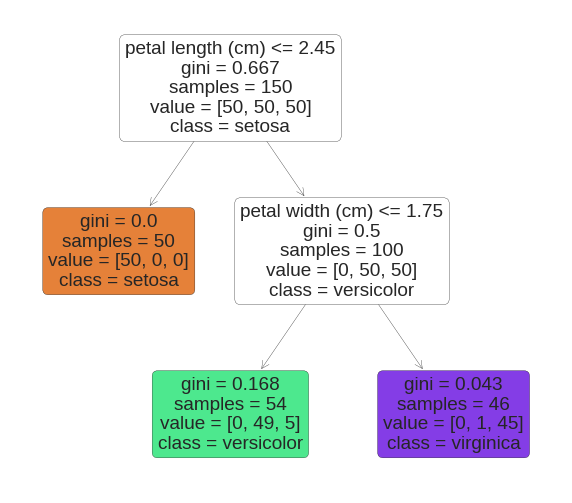

In [19]:
plt.figure(figsize=(10, 9))
plot_tree(clf, 
          feature_names=iris.feature_names[2:], 
          class_names=iris.target_names, 
          rounded=True,
          filled=True);

In [21]:
# this probabilities are computed in the following way
# - tree is traversed from the root to some leaf based conditions 
# - if the leaf is not pure (not all samples belong to the same class)
#   probability for each class is computed as a ratio of the intances that are represented 
#   by the leaf, belonging to class k, and the total number of instances represented by the
#   same leaf
clf.predict_proba([[5, 1.5]]) # [0, 49, 5] / 54

array([[0.        , 0.90740741, 0.09259259]])

# TRAINING DECISION TREE ON MOONS SET

In [39]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score

In [36]:
X, y = make_moons(n_samples=10000, noise=0.4)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
clf = DecisionTreeClassifier(max_leaf_nodes=50)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=50,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [63]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print('TRAIN')
print(confusion_matrix(y_train, y_pred_train))
print(f'f1: {f1_score(y_train, y_pred_train)}')
print()
print('TEST')
print(confusion_matrix(y_test, y_pred_test))
print(f'f1: {f1_score(y_test, y_pred_test)}')

TRAIN
[[3607  399]
 [ 627 3367]]
f1: 0.8677835051546392

TEST
[[874 120]
 [173 833]]
f1: 0.8504338948443083


In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'max_leaf_nodes': [5, 10, 25, 50, 100, 500],
        'max_depth': [2, 4, 6, 8, 10, 15, 25, 50, 100],
        'criterion': ['gini', 'entropy']
    }
]

grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           n_jobs=-1, 
                           cv=5)

grid_search = grid_search.fit(X_train, y_train)

In [74]:
grid_search.best_params_, grid_search.best_score_

({'criterion': 'entropy', 'max_depth': 8, 'max_leaf_nodes': 25}, 0.857)

In [83]:
param_grid = [
    {
        'max_leaf_nodes': [10, 20, 21, 22, 23, 24, 25],
        'max_depth': [6, 7, 8, 9, 10],
        'criterion': ['gini', 'entropy']
    }
]

grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           n_jobs=-1, 
                           cv=5)

grid_search = grid_search.fit(X_train, y_train)

In [84]:
grid_search.best_params_, grid_search.best_score_

({'criterion': 'entropy', 'max_depth': 7, 'max_leaf_nodes': 22}, 0.85725)

# BUILDING ENSEMBLE OF DECISION TREES

In [103]:
# generate 1000 subsets of the previous set, each containing 100 random samples
def split_dataset(X, y, n_samples, n_splits):
    datasets = []
    
    for i in range(n_splits):
        rand_indices = np.random.choice(range(len(X)), size=n_samples)
        dataset = {'X': X[rand_indices, :], 'y': y[rand_indices]}
        datasets.append(dataset)
    
    return datasets

subsets = split_dataset(X_train, y_train, n_samples=100, n_splits=1000)

In [109]:
# testing single tree
tree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=22, max_depth=7)
tree.fit(subsets[0]['X'], subsets[0]['y'])
tree.score(X_test, y_test)

0.7935

In [140]:
# building 1000 trees
trees = []
predictions = np.array([])

for dset in subsets:
    tree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=22, max_depth=7)
    tree.fit(dset['X'], dset['y'])
    trees.append(tree)

for tree in trees:
    y_pred = tree.predict(X_test)
    
    if len(predictions) == 0:
        predictions = y_pred
    else:
        predictions = np.c_[predictions, y_pred]

In [154]:
print(predictions), len(predictions)

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [1 0 0 ... 1 0 0]
 [1 1 1 ... 1 1 1]]


(None, 2000)

In [164]:
from scipy.stats import mode

y_pred = mode(predictions, axis=1)[0].ravel()

In [165]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8615